%load_ext autoreload
%autoreload 2# Evaluate forecasts

In this notebook, we will compute all the scores for the baseline models and create the figures for the paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import os
NOTEBOOK_PATH = "/g/data/wb00/admin/testing/weatherbench/NCI_notebooks" 
warnings.filterwarnings('ignore')
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.chdir (f'{NOTEBOOK_PATH}/src')
from score import *
import numpy as np
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dropout, Conv2D, Lambda, LeakyReLU
from tensorflow.python.client import device_lib
from dask.diagnostics import ProgressBar
from datetime import datetime
import train_nn
print (f"\nTF Device: {tf.config.list_physical_devices('GPU')}" )
train_nn.limit_mem()
from dask.distributed import Client
client = Client(n_workers=12, threads_per_worker=1)  
client

2024-02-12 17:09:28.971937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.



TF Device: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-12 17:09:30.987277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.events-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/opt/conda/envs/mlenv/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  war

<Client: 'tcp://127.0.0.1:37219' processes=12 threads=12, memory=95.00 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from score import *
from collections import OrderedDict

In [4]:
import pickle
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [5]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [6]:
res = '5.625'
#DATADIR = f'/data/WeatherBench/{res}deg/'
#PREDDIR = '/data/WeatherBench/baselines/'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print(DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print(PREDDIR)

/g/data/wb00/NCI-Weatherbench/5.625deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [7]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the validation subset of the data: 2017 and 2018
# Ok, actually it's the TEST data but here we will just call it valid
print (f'{DATADIR}/geopotential_500/')
#z500_valid = load_test_data(f'{DATADIR}/geopotential_500/', 'z', slice('2021', '2022'))
#t850_valid = load_test_data(f'{DATADIR}/temperature_850/', 't', slice('2021', '2022'))
z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022'))
t850_valid = load_test_data(f'{DATADIR}/temperature/', 't', slice('2021', '2022'))
# for precipitation we are taking 6 hourly accumulations
tp_valid = load_test_data(f'{DATADIR}/total_precipitation/', 'tp', slice('2021', '2022')).rolling(time=6).sum()
tp_valid.name = 'tp'
t2m_valid = load_test_data(f'{DATADIR}/2m_temperature/', 't2m', slice('2021', '2022'))
valid_data = xr.merge([z500_valid, t850_valid, tp_valid, t2m_valid])

[2024-02-12 17:09:33]
/g/data/wb00/NCI-Weatherbench/5.625deg/geopotential_500/
var: z
var: t
var: tp
var: t2m
CPU times: user 2.47 s, sys: 316 ms, total: 2.79 s
Wall time: 3.63 s


## Load data

First let's load all the prediction files from the previous notebooks.

In [8]:
# to speed things up, let's only evaluate every 6th hour
valid_data = valid_data.isel(time=slice(0, None, 6))

In [9]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

persistence = xr.open_dataset(f'{PREDDIR}/persistence_{res}.nc', chunks={'time': 10}).load()
climatology = xr.open_dataset(f'{PREDDIR}/climatology_{res}.nc', chunks={'time': 10}).load()
weekly_climatology = xr.open_dataset(f'{PREDDIR}/weekly_climatology_{res}.nc', chunks={'time': 10}).load()

[2024-02-12 17:09:37]
CPU times: user 1min 21s, sys: 21 s, total: 1min 42s
Wall time: 3min 49s


In [10]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

variables = ['z', 't', 'tp', 't2m']
lr_3d = xr.merge([xr.open_dataset(f'{PREDDIR}/lr_3d_{v}_{v}.nc', chunks={'time': 10}) for v in variables]).load()
lr_5d = xr.merge([xr.open_dataset(f'{PREDDIR}/lr_5d_{v}_{v}.nc', chunks={'time': 10}) for v in variables]).load()
lr_6h_iter = xr.open_dataset(f'{PREDDIR}/lr_6h_iter.nc', chunks={'time': 10}).load()

[2024-02-12 17:13:27]
CPU times: user 1min 4s, sys: 19.3 s, total: 1min 24s
Wall time: 2min 55s


In [11]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

#cnn_3d = xr.open_dataset(f'{PREDDIR}/fccnn_3d.nc')
#cnn_5d = xr.open_dataset(f'{PREDDIR}/fccnn_5d.nc')
cnn_3d = xr.open_dataset(f'{PREDDIR}/cnn_3d.nc', chunks={'time': 10})
cnn_5d = xr.open_dataset(f'{PREDDIR}/cnn_5d.nc', chunks={'time': 10})
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}/fccnn_6h_iter.nc', chunks={'time': 10})

[2024-02-12 17:16:22]
CPU times: user 44.7 ms, sys: 11.1 ms, total: 55.8 ms
Wall time: 49.7 ms


In [12]:
cnn_6h_iter 

<xarray.Dataset>
Dimensions:    (lead_time: 20, time: 17514, lat: 32, lon: 64)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T17:00:00
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z          (lead_time, time, lat, lon) float32 dask.array<chunksize=(20, 10, 32, 64), meta=np.ndarray>
    t          (lead_time, time, lat, lon) float32 dask.array<chunksize=(20, 10, 32, 64), meta=np.ndarray>

In [13]:
# See next section on how to compute these from the raw data.
#tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
#t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')
#t63 = xr.open_dataset(f'{PREDDIR}/t63_5.625deg.nc')

## TIGGE data

*You do not need to execute these steps for TIGGE and T42/T63 if you already opened the datasets in the cell above.*

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

Note that the `tigge_z_t` file was preprocessed with a previous version of the TIGGE data. Unfortunatly, some of the data on the MARS archive seem to be corrupted at the moment. For the `t2m` and `tp` fields only the files for from 2018-1 to 2018-12 were downloadable at the time.

In [14]:
variables = ['2m_temperature', 'total_precipitation']

In [15]:
#tigge_raw = xr.merge([
#    xr.open_mfdataset(
#        f'/media/rasp/Elements/WeatherBench/tigge/{res}deg/{v}/*2018*.nc',
#        combine='by_coords'
#    ).squeeze().drop(['valid_time'])   # Necessaary to avoid weird error
#    for v in variables
#])

In [16]:
#tigge_raw = tigge_raw.rename({'step': 'lead_time'})

In [17]:
# Again we want 6 hourly accumulations, not accumulation since initialization
# Further we want [m] not [kg m**-2], so we divide by 1000
#tigge_raw['tp'] = tigge_raw.tp.diff('lead_time') / 1000.

In [18]:
#tigge_z_t = xr.open_dataset(f'{PREDDIR}/tigge_z_t_{res}deg.nc')

In [19]:
#tigge_raw['lead_time'] = tigge_z_t.lead_time

In [20]:
#tigge = xr.merge([tigge_z_t, tigge_raw])

In [21]:
# Save for later usage
#tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')

## IFS T42 and T63

These are IFS forecasts run at lower resolutions. Again we need to do some preprocessing

In [22]:
def convert_time(ds, nlead_time, dt_h=6):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, dt_h*nlead_time, dt_h), dims=['lead_time'], coords={'lead_time': np.arange(0, dt_h*nlead_time, dt_h)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [23]:
def fix_lat_lon(ds):
    "Not necessary for current version"
    ds = ds.sortby('lat')
    ds['lat'] = valid_data.lat
    ds = ds.roll(lon=32, roll_coords='lon')
    ds['lon'] = valid_data.lon
    return ds

#### T42

In [24]:
#!ls -lh /media/rasp/Elements/WeatherBench/IFS_T42/*.nc

In [25]:
#t42_raw1 = xr.open_mfdataset(
#    '/media/rasp/Elements/WeatherBench/IFS_T42/output_42_pl_5.625*.nc',
#    combine='nested', concat_dim='time'
#)
#t42_raw2 = xr.open_mfdataset(
#    '/media/rasp/Elements/WeatherBench/IFS_T42/output_42_sfc_5.625*.nc',
#    combine='nested', concat_dim='time'
#)

In [26]:
#t42_raw = xr.merge([t42_raw1, fix_lat_lon(t42_raw2)])

In [27]:
3045/29

105.0

In [28]:
# Pick variables we want to evaluate
#t42 = xr.merge([
#    t42_raw.z.sel(lev=500e2).drop('lev'),
#    t42_raw.t.sel(lev=850e2).drop('lev'),
#    t42_raw['2t']
#])

In [29]:
#t42 = convert_time(t42, 29)

In [30]:
#t42 = t42.sortby('time').rename({'2t': 't2m'})

In [31]:
#t42.to_netcdf(f'{PREDDIR}/t42_5.625deg.nc')

#### T63

In [32]:
#t63_raw1 = xr.open_mfdataset(
#    '/media/rasp/Elements/WeatherBench/IFS_T63/output_63_pl_5.625*.nc',
#    combine='nested', concat_dim='time'
#)
#t63_raw2 = xr.open_mfdataset(
#    '/media/rasp/Elements/WeatherBench/IFS_T63/output_63_sfc_5.625*.nc',
#    combine='nested', concat_dim='time'
#)

In [33]:
#t63_raw = fix_lat_lon(xr.merge([t63_raw1, t63_raw2]))

In [34]:
1575/15

105.0

In [35]:
# Pick variables we want to evaluate
#t63 = xr.merge([
#    t63_raw.z.sel(lev=500e2).drop('lev'),
#    t63_raw.t.sel(lev=850e2).drop('lev'),
#    t63_raw['2t']
#])

In [36]:
#t63 = convert_time(t63, 15, 12)

In [37]:
#t63 = t63.sortby('time').rename({'2t': 't2m'})

In [38]:
#t63.to_netcdf(f'{PREDDIR}/t63_5.625deg.nc')

## Compute RMSE

In [39]:
import importlib
#importlib.reload(score)
#persistence.dims

In [40]:
#%%time
#func = compute_weighted_rmse
#Persistence = evaluate_iterative_forecast(persistence, valid_data, func)#.load()
#Persistence = xr.concat(Persistence, 'lead_time').compute()

In [41]:
#%%time
#func = compute_weighted_rmse
#Climatology = func(climatology, valid_data).compute() 

In [42]:
#%%time
#func = compute_weighted_rmse
#Weekly_clim = func(weekly_climatology, valid_data).compute() 

In [43]:
#%%time
#func = compute_weighted_rmse
#LR_iterative = evaluate_iterative_forecast(lr_6h_iter, valid_data, func) 
#LR_iterative = xr.concat(LR_iterative, 'lead_time').compute()

In [44]:
#cnn_6h_iter['lead_time']

In [45]:
#lr_6h_iter

In [46]:
#%%time
#func = compute_weighted_rmse
#CNN_iterative = evaluate_iterative_forecast(cnn_6h_iter, valid_data, func) 
#CNN_iterative = xr.concat(CNN_iterative, 'lead_time').compute()

In [47]:
#%%time
#func = compute_weighted_rmse
#LR_direct = xr.concat(
#        [
#            func(lr_3d, valid_data).compute(),
#            func(lr_5d, valid_data).compute()
#        ],
#        dim=pd.Index([72, 120], name='lead_time')
#    )

In [48]:
#%%time
#CNN_direct = xr.concat(
#        [
#            compute_weighted_rmse(cnn_3d, valid_data).compute(),
#            compute_weighted_rmse(cnn_5d, valid_data).compute()
#        ],
#        dim=pd.Index([72, 120], name='lead_time')
#    )

In [49]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

func = compute_weighted_rmse
rmse = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    #'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    #'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    #'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            compute_weighted_rmse(cnn_3d, valid_data),
            compute_weighted_rmse(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

[2024-02-12 17:16:24]
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 6
Data variables:
    z          float64 236.8
    t          float64 1.589
    tp         float64 0.002339
    t2m        float64 2.826, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 12
Data variables:
    z          float64 377.5
    t          float64 2.355
    tp         float64 0.002845
    t2m        float64 3.823, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 18
Data variables:
    z          float64 517.2
    t          float64 2.794
    tp         float64 0.002986
    t2m        float64 3.215, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 24
Data variables:
    z          float64 606.6
    t          float64 3.105
    tp         float64 0.00304
    t2m        float64 2.147, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 30
Data variables:
    z          float64 695.3
    t          float64 3.498
  

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


CPU times: user 32min 6s, sys: 1min 24s, total: 33min 30s
Wall time: 33min 47s


In [50]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

func = compute_weighted_acc
acc = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    #'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    #'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    #'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

[2024-02-12 17:50:12]
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 6
Data variables:
    z          float64 0.9758
    t          float64 0.9589
    tp         float64 0.494
    t2m        float64 0.8939, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 12
Data variables:
    z          float64 0.9385
    t          float64 0.9098
    tp         float64 0.2517
    t2m        float64 0.8057, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 18
Data variables:
    z          float64 0.8845
    t          float64 0.8731
    tp         float64 0.1755
    t2m        float64 0.8626, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 24
Data variables:
    z          float64 0.8411
    t          float64 0.8431
    tp         float64 0.1457
    t2m        float64 0.9387, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 30
Data variables:
    z          float64 0.7913
    t          float64 0.8

In [51]:
# ACC does not work with NaNs, so we have to fix TIGGE manually
#correct = evaluate_iterative_forecast(tigge.sel(time='2018'), valid_data.sel(time='2018'), func).load()

In [52]:
#acc['Operational']['tp'] = correct['tp']
#acc['Operational']['t2m'] = correct['t2m']

In [53]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

func = compute_weighted_mae
mae = OrderedDict({
    'Persistence': evaluate_iterative_forecast(persistence, valid_data, func).load(),
    'Climatology': func(climatology, valid_data).load(),
    'Weekly clim.': func(weekly_climatology, valid_data).load(),
    #'Operational': evaluate_iterative_forecast(tigge, valid_data, func).load(),
    #'IFS T42': evaluate_iterative_forecast(t42, valid_data, func).load(),
    #'IFS T63': evaluate_iterative_forecast(t63, valid_data, func).load(),
    'LR (iterative)': evaluate_iterative_forecast(lr_6h_iter, valid_data, func).load(),
    'CNN (iterative)': evaluate_iterative_forecast(cnn_6h_iter, valid_data, func).load(),
    'LR (direct)': xr.concat(
        [
            func(lr_3d, valid_data),
            func(lr_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
    'CNN (direct)': xr.concat(
        [
            func(cnn_3d, valid_data),
            func(cnn_5d, valid_data)
        ],
        dim=pd.Index([72, 120], name='lead_time')
    ).load(),
})

[2024-02-12 19:12:13]
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 6
Data variables:
    z          float64 169.7
    t          float64 1.05
    tp         float64 0.0006934
    t2m        float64 1.534, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 12
Data variables:
    z          float64 216.6
    t          float64 1.571
    tp         float64 0.0008896
    t2m        float64 2.147, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 18
Data variables:
    z          float64 327.6
    t          float64 1.843
    tp         float64 0.0009493
    t2m        float64 1.916, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 24
Data variables:
    z          float64 352.7
    t          float64 2.012
    tp         float64 0.000968
    t2m        float64 1.296, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 30
Data variables:
    z          float64 436.3
    t          float64 2.328

In [54]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

to_pickle(rmse, f'{PREDDIR}rmse.pkl')
to_pickle(acc, f'{PREDDIR}acc.pkl')
to_pickle(mae, f'{PREDDIR}mae.pkl')

[2024-02-12 19:55:19]
CPU times: user 4.41 ms, sys: 1.53 ms, total: 5.93 ms
Wall time: 6.66 ms


# Loading from the saved objects

In [55]:
%%time
from datetime import datetime
print( f'[{datetime.now().replace(microsecond=0)}]' )

rmse = read_pickle(f'{PREDDIR}rmse.pkl')
acc = read_pickle(f'{PREDDIR}acc.pkl')
mae = read_pickle(f'{PREDDIR}mae.pkl')

[2024-02-12 19:55:19]
CPU times: user 3.24 ms, sys: 845 µs, total: 4.09 ms
Wall time: 3.76 ms


In [56]:
colors = {
    'Persistence': '0.2',
    'Climatology': '0.5',
    'Weekly clim.': '0.7',
    
    #'Operational': '#984ea3',
    #'IFS T42': '#4daf4a',
    #'IFS T63': '#377eb8',
    'LR (iterative)': '#ff7f00',
    'LR (direct)': '#ff7f00',
    'CNN (iterative)': '#e41a1c',
    'CNN (direct)': '#e41a1c',
}

In [57]:
def create_plot(score, var, save_fn=None, ax=None, legend=False, ylabel=None, title=None, ylim=None, mult_tp=1.):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    for exp, ds in score.items():
        s = ds.copy(deep=True)
        if var in s.variables:
            if var == 'tp': s[var] *= mult_tp
            if exp in ['Climatology', 'Weekly clim.']:
                ax.axhline(s[var], ls='--', c=colors[exp], label=exp, lw=3)
            elif 'direct' in exp:
                ax.scatter(s['lead_time'], s[var], c=colors[exp], s=100, label=exp, lw=2, edgecolors='k', zorder=10)
            else:
                s[var].plot(c=colors[exp], label=exp, lw=3, ax=ax)
            
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.set_xlim(0, 122)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time [days]')
    
    if not save_fn is None: 
        plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
        fig.savefig(save_fn)

[2024-02-12 19:55:19]
CPU times: user 206 ms, sys: 24 ms, total: 230 ms
Wall time: 214 ms


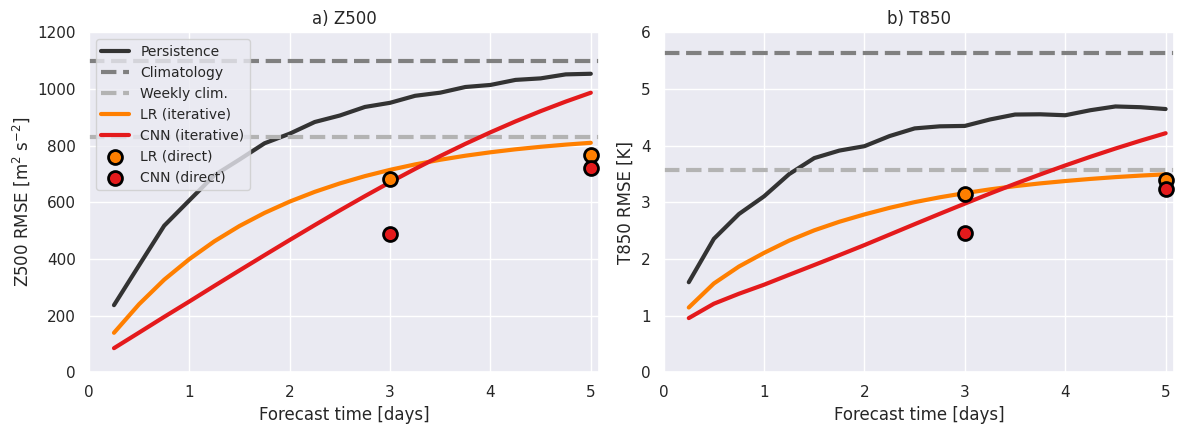

In [58]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 'z', ax=ax1, ylabel=r'Z500 RMSE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 1200))
create_plot(rmse, 't', ax=ax2, ylabel=r'T850 RMSE [K]', title='b) T850', ylim=(0, 6))
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
#fig.savefig('../figures/rmse.pdf', bbox_inches='tight')

In [59]:
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
#create_plot(rmse, 'z', ax=ax1, ylabel=r'Z500 RMSE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 1200))
#create_plot(rmse, 't', ax=ax2, ylabel=r'T850 RMSE [K]', title='b) T850', ylim=(0, 6))
#ax1.legend(loc=2, ncol=1, fontsize=10)
#plt.tight_layout()
#fig.savefig('../figures/rmse.pdf', bbox_inches='tight')

[2024-02-12 19:55:20]
CPU times: user 107 ms, sys: 34 ms, total: 141 ms
Wall time: 130 ms


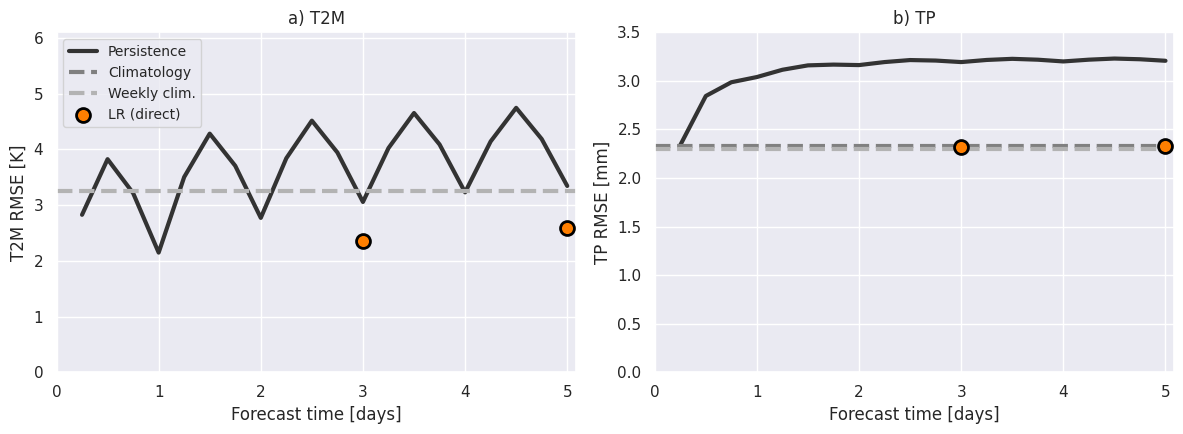

In [60]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
create_plot(rmse, 't2m', ax=ax1, ylabel=r'T2M RMSE [K]', title='a) T2M', ylim=(0, 6.1))
create_plot(rmse, 'tp', ax=ax2, ylabel=r'TP RMSE [mm]', title='b) TP', ylim=(0, 3.5), mult_tp=1e3)
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
#fig.savefig('../figures/rmse2.pdf', bbox_inches='tight')

[2024-02-12 19:55:21]
CPU times: user 232 ms, sys: 27.3 ms, total: 260 ms
Wall time: 234 ms


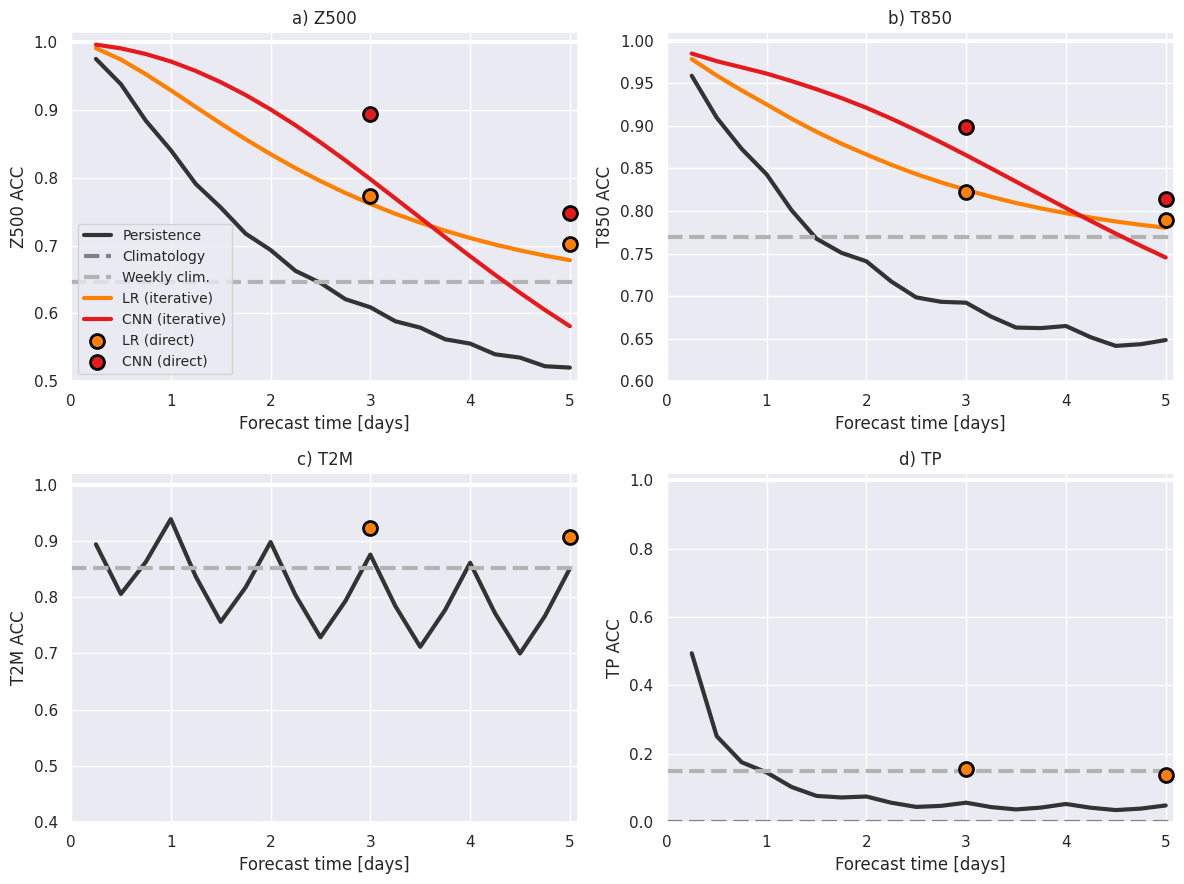

In [61]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
create_plot(acc, 'z', ax=ax1, ylabel=r'Z500 ACC', title='a) Z500', ylim=(0.5, 1.015))
create_plot(acc, 't', ax=ax2, ylabel=r'T850 ACC', title='b) T850', ylim=(0.6, 1.01))
create_plot(acc, 't2m', ax=ax3, ylabel=r'T2M ACC', title='c) T2M', ylim=(0.4, 1.02))
create_plot(acc, 'tp', ax=ax4, ylabel=r'TP ACC', title='d) TP', ylim=(0., 1.02))
ax1.legend(loc=3, ncol=1, fontsize=10)
for ax in axs.flat:
    ax.axhline(1, zorder=1, c='w', lw=3)
plt.tight_layout()
#fig.savefig('../figures/acc.pdf', bbox_inches='tight')

[2024-02-12 19:55:22]
CPU times: user 244 ms, sys: 51 ms, total: 295 ms
Wall time: 262 ms


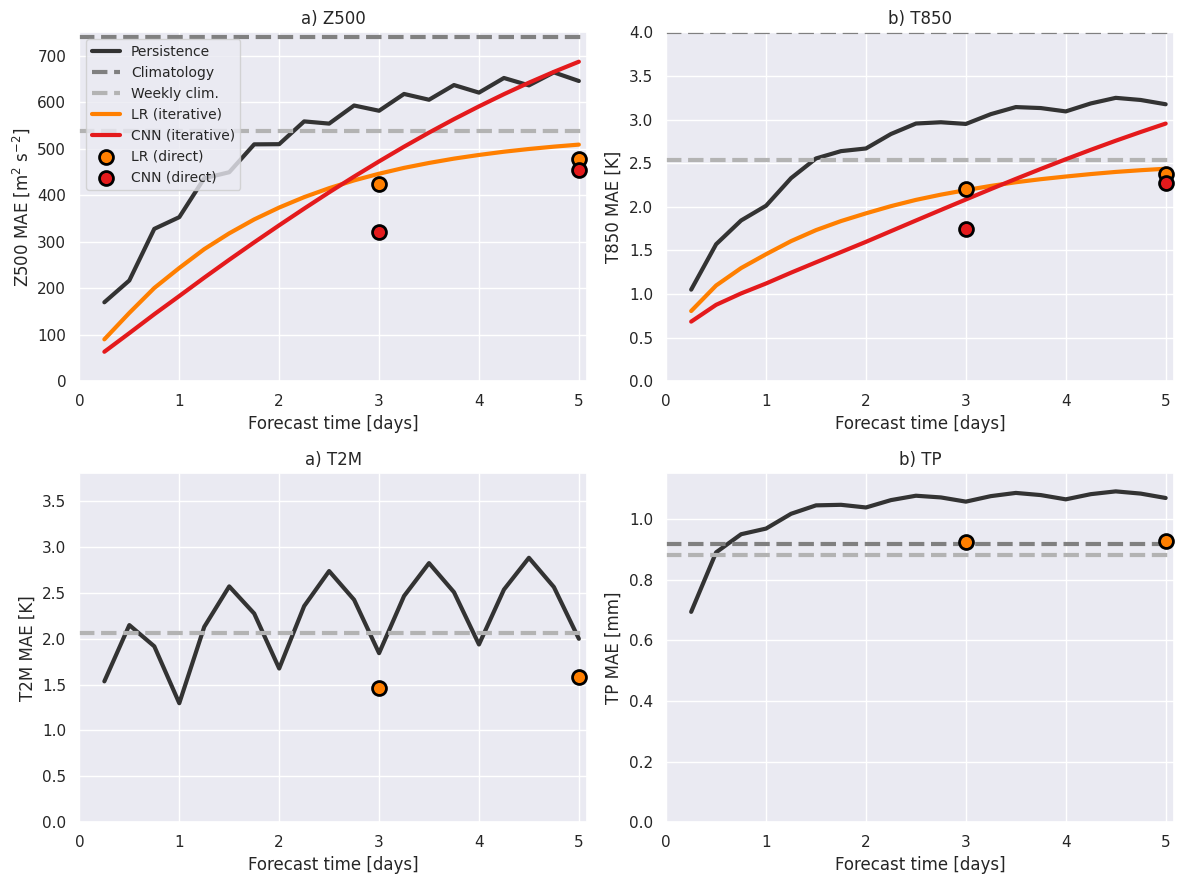

In [62]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
((ax1, ax2), (ax3, ax4)) = axs
create_plot(mae, 'z', ax=ax1, ylabel=r'Z500 MAE [m$^2$ s$^{-2}$]', title='a) Z500', ylim=(0, 750))
create_plot(mae, 't', ax=ax2, ylabel=r'T850 MAE [K]', title='b) T850', ylim=(0, 4))
create_plot(mae, 't2m', ax=ax3, ylabel=r'T2M MAE [K]', title='a) T2M', ylim=(0, 3.8))
create_plot(mae, 'tp', ax=ax4, ylabel=r'TP MAE [mm]', title='b) TP', ylim=(0, 1.15), mult_tp=1e3)
ax1.legend(loc=2, ncol=1, fontsize=10)
plt.tight_layout()
#fig.savefig('../figures/mae.pdf', bbox_inches='tight')

In [63]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# for tables. Yeah I know ugly formatting...
for k, v in rmse.items():
    if hasattr(v, 'lead_time'):
        print(k, v.sel(lead_time=[72, 120]).to_dataframe())
    else:
        print(k, v)

[2024-02-12 19:55:23]
Persistence                      z         t        tp       t2m
lead_time                                           
72          951.203245  4.347990  0.003194  3.055965
120        1053.753268  4.646031  0.003207  3.343070
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 1.098e+03
    t        float64 5.629
    tp       float64 0.002332
    t2m      float64 6.193
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 830.8
    t        float64 3.575
    tp       float64 0.0023
    t2m      float64 3.257
LR (iterative)                     z         t
lead_time                      
72         714.544616  3.161986
120        810.046630  3.493936
CNN (iterative)                     z         t
lead_time                      
72         670.847976  2.976915
120        986.875267  4.219458
LR (direct)                     z         t     

In [64]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# for tables
for k, v in acc.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[72, 120]).to_dataframe().round(2)

        print(k, df)
    else:
        print(k, v)

[2024-02-12 19:55:23]
Persistence               z     t    tp   t2m
lead_time                        
72         0.61  0.69  0.06  0.88
120        0.52  0.65  0.05  0.85
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 1.77e-06
    t        float64 -3.021e-06
    tp       float64 -1.012e-07
    t2m      float64 2.554e-06
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 0.6462
    t        float64 0.7693
    tp       float64 0.1506
    t2m      float64 0.8522
LR (iterative)               z     t
lead_time            
72         0.76  0.82
120        0.68  0.78
CNN (iterative)               z     t
lead_time            
72         0.80  0.87
120        0.58  0.75
LR (direct)               z     t    tp   t2m
lead_time                        
72         0.77  0.82  0.16  0.92
120        0.70  0.79  0.14  0.91
CNN (direct)               z     t
lead_tim

In [65]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# for tables
for k, v in mae.items():
    if hasattr(v, 'lead_time'):
        df = v.sel(lead_time=[72, 120]).to_dataframe()
        try:
            df['tp'] *= 1000
        except KeyError:
            pass
        df['z'] = df['z'].round()
        print(k, df.round(2))
    else:
        print(k, v)

[2024-02-12 19:55:23]
Persistence                z     t    tp   t2m
lead_time                         
72         581.0  2.95  1.06  1.84
120        645.0  3.18  1.07  2.00
Climatology <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 739.1
    t        float64 4.006
    tp       float64 0.000916
    t2m      float64 3.843
Weekly clim. <xarray.Dataset>
Dimensions:  ()
Coordinates:
    level    int32 500
Data variables:
    z        float64 537.4
    t        float64 2.541
    tp       float64 0.00088
    t2m      float64 2.057
LR (iterative)                z     t
lead_time             
72         446.0  2.19
120        509.0  2.44
CNN (iterative)                z     t
lead_time             
72         473.0  2.08
120        687.0  2.95
LR (direct)                z     t    tp   t2m
lead_time                         
72         424.0  2.20  0.92  1.46
120        479.0  2.38  0.93  1.58
CNN (direct)                z     t
lead_ti

## Other figures for paper

In [66]:
import cartopy.crs as ccrs

In [67]:
sns.set_style('dark')

[2024-02-12 19:55:23]
CPU times: user 5.86 s, sys: 719 ms, total: 6.58 s
Wall time: 6.71 s


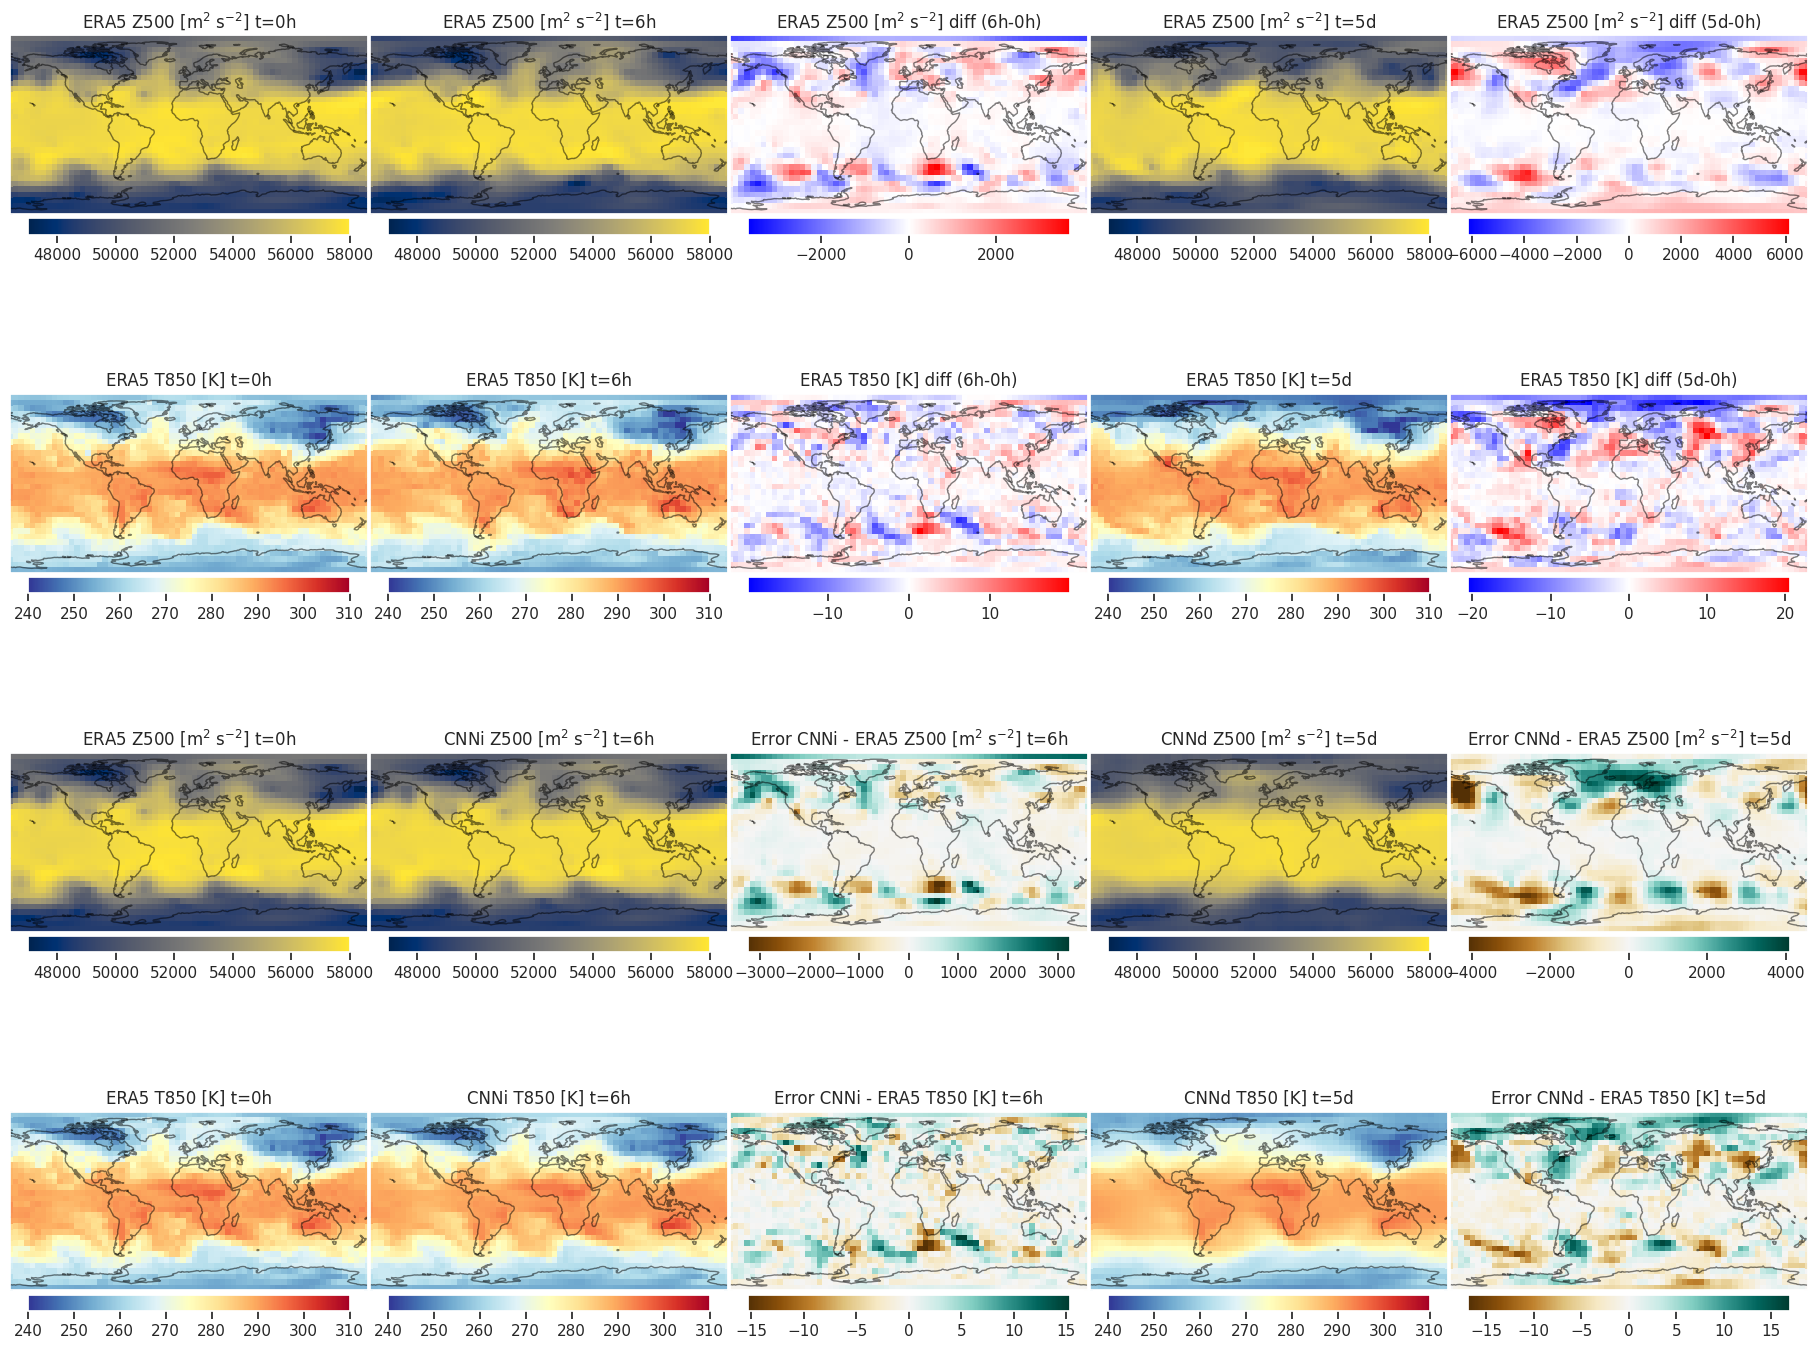

In [68]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

cmap_z = 'cividis'
cmap_t = 'RdYlBu_r'
cmap_diff = 'bwr'
cmap_error = 'BrBG'

def imcol(ax, data, title='', **kwargs):
    if not 'vmin' in kwargs.keys():
        mx = np.abs(data.max().values)
        kwargs['vmin'] = -mx; kwargs['vmax'] = mx
#     I = ax.imshow(data, origin='lower',  **kwargs)
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, add_labels=False, 
                  rasterized=True, **kwargs)
    cb = fig.colorbar(I, ax=ax, orientation='horizontal', pad=0.01, shrink=0.90)
    ax.set_title(title)
    ax.coastlines(alpha=0.5)

#fig, axs = plt.subplots(6, 5, figsize=(18, 15), subplot_kw={'projection': ccrs.PlateCarree()})
fig, axs = plt.subplots(4, 5, figsize=(18, 15), subplot_kw={'projection': ccrs.PlateCarree()})
#
# True
for iax, var, cmap, r, t in zip(
    [0, 1], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], valid_data[var].isel(time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=6h')
    imcol(axs[iax,2],
        valid_data[var].isel(time=6)-valid_data[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (6h-0h)')
    imcol(axs[iax,3], valid_data[var].isel(time=5*24), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=5d')
    imcol(axs[iax,4], 
        valid_data[var].isel(time=5*24)-valid_data[var].isel(time=0), cmap=cmap_diff, 
        title=f'ERA5 {t} diff (5d-0h)')

# CNN
for iax, var, cmap, r, t in zip(
    [2, 3], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
    imcol(axs[iax,0], valid_data[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
    imcol(axs[iax,1], cnn_6h_iter[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNi {t} t=6h')
    imcol(axs[iax,2], 
        cnn_6h_iter[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), cmap=cmap_error,
        title=f'Error CNNi - ERA5 {t} t=6h')
    imcol(axs[iax,3], cnn_5d[var].isel(time=0), cmap=cmap, 
          vmin=r[0], vmax=r[1], title=f'CNNd {t} t=5d')
    imcol(axs[iax,4], 
        cnn_5d[var].isel(time=0) - valid_data[var].isel(time=5*24), cmap=cmap_error,
        title=f'Error CNNd - ERA5 {t} t=5d')

## IFS
#for iax, var, cmap, r, t in zip(
#    [4, 5], ['z', 't'], [cmap_z, cmap_t], [[47000, 58000], [240, 310]], [r'Z500 [m$^2$ s$^{-2}$]', 'T850 [K]']):
#    imcol(axs[iax,0], tigge[var].isel(time=0).sel(lead_time=0), cmap=cmap, 
#          vmin=r[0], vmax=r[1], title=f'ERA5 {t} t=0h')
#    imcol(axs[iax,1], tigge[var].isel(time=0).sel(lead_time=6), cmap=cmap, 
#          vmin=r[0], vmax=r[1], title=f'IFS {t} t=6h')
#    imcol(axs[iax,2], 
#        tigge[var].isel(time=0).sel(lead_time=6)-valid_data[var].isel(time=6), cmap=cmap_error,
#          title=f'Error IFS - ERA5 {t} t=6h')
#    imcol(axs[iax,3], tigge[var].isel(time=0).sel(lead_time=5*24), cmap=cmap, 
#          vmin=r[0], vmax=r[1], title=f'IFS {t} t=5d')
#    imcol(axs[iax,4], 
#        tigge[var].isel(time=0).sel(lead_time=5*24) - valid_data[var].isel(time=5*24), cmap=cmap_error,
#        title=f'Error IFS - ERA5 {t} t=5d')
for ax in axs.flat:
    ax.set_xticks([]); ax.set_yticks([])
plt.tight_layout(pad=0)
#plt.savefig('../figures/examples.pdf', bbox_inches='tight')
# plt.savefig('../figures/examples.jpeg', bbox_inches='tight', dpi=300)

In [69]:
def plot_map(data, fn, cmap, vmin, vmax):
    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree()})
    I = data.plot(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False, 
                  add_labels=False, cmap=cmap, vmin=vmin, vmax=vmax, rasterized=True)
    I.set_edgecolor('face')
    ax.set_xticks([]); ax.set_yticks([]); ax.coastlines(alpha=0.5, lw=2)
    plt.subplots_adjust(0, 0, 1, 1)
    fig.savefig(fn, bbox_inches=0, transparent='true')

In [70]:
#plot_map(valid_data.z.isel(time=0), '../figures/z_0.pdf', 'cividis', 47000, 58000)
#plot_map(valid_data.z.isel(time=6), '../figures/z_6h.pdf', 'cividis', 47000, 58000)
#plot_map(valid_data.z.isel(time=5*24), '../figures/z_5d.pdf', 'cividis', 47000, 58000)

In [71]:
#plot_map(valid_data.t.isel(time=0), '../figures/t_0.pdf', 'RdYlBu_r', 240, 310)
#plot_map(valid_data.t.isel(time=6), '../figures/t_6h.pdf', 'RdYlBu_r', 240, 310)
#plot_map(valid_data.t.isel(time=5*24), '../figures/t_5d.pdf', 'RdYlBu_r', 240, 310)

# Same for higher resolutions

Let's now see how the number change if we do the same for higher resolutions.

In [72]:
res = '2.8125'
#DATADIR = f'/media/rasp/Elements/weather-benchmark/{res}deg/'
#PREDDIR = '/data/weather-benchmark/predictions/'
DATADIR = f'/g/data/wb00/NCI-Weatherbench/{res}deg' 
print(DATADIR)
PREDDIR = f"/scratch/vp91/{os.environ['USER']}/NCI-Weatherbench/pred_dir"
print(PREDDIR)

/g/data/wb00/NCI-Weatherbench/2.8125deg
/scratch/vp91/mah900/NCI-Weatherbench/pred_dir


In [73]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}/geopotential/', 'z', slice('2021', '2022'))
t850_valid = load_test_data(f'{DATADIR}/temperature/', 't', slice('2021', '2022'))
valid_data = xr.merge([z500_valid, t850_valid])

[2024-02-12 19:55:33]
var: z
var: t
CPU times: user 2.02 s, sys: 223 ms, total: 2.24 s
Wall time: 2.48 s


In [74]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

persistence = xr.open_dataset(f'{PREDDIR}/persistence_{res}.nc', chunks={'time': 10}).load()#)
climatology = xr.open_dataset(f'{PREDDIR}/climatology_{res}.nc', chunks={'time': 10}).load()#)
weekly_climatology = xr.open_dataset(f'{PREDDIR}/weekly_climatology_{res}.nc', chunks={'time': 10}).load()#)

[2024-02-12 19:55:35]
CPU times: user 1min 4s, sys: 33 s, total: 1min 37s
Wall time: 3min 26s


In [75]:
# Convert from geopotential height to geopotential
#tigge_raw_z = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/z*.nc').squeeze()
#tigge_raw_t = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/tigge/{res}deg/t*.nc').squeeze()

In [76]:
#tigge_raw = xr.merge([tigge_raw_z.drop('lev'), tigge_raw_t.drop('lev')])

In [77]:
#tigge_raw

In [78]:
# Convert from geopotential height to geopotential
#tigge_raw['z'] = tigge_raw.gh * 9.807
#tigge_raw

In [79]:
#tigge_raw = tigge_raw.drop('gh')

In [80]:
#tigge = convert_time(tigge_raw, 21)

In [81]:
#tigge

In [82]:
## Save for later usage
#tigge.to_netcdf(f'{PREDDIR}/tigge_{res}deg.nc')

In [83]:
# See next section on how to compute these from the raw data.
#tigge = xr.open_dataset(f'{PREDDIR}/tigge_{res}deg.nc')
# t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')
# t42 = xr.open_dataset(f'{PREDDIR}/t42_5.625deg.nc')

In [84]:
#tigge_rmse = evaluate_iterative_forecast(tigge, valid_data).load()
# t21_rmse = evaluate_iterative_forecast(t21, valid_data).load()
# t42_rmse = evaluate_iterative_forecast(t42, valid_data).load()

In [85]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

rmse_persistence = evaluate_iterative_forecast(persistence, valid_data, compute_weighted_rmse).load()
rmse_climatology = compute_weighted_rmse(climatology, valid_data).load()
rmse_weekly_climatology = compute_weighted_rmse(weekly_climatology, valid_data).load()

[2024-02-12 19:59:03]
<xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 6
Data variables:
    z          float64 236.3
    t          float64 1.591, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 12
Data variables:
    z          float64 377.4
    t          float64 2.361, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 18
Data variables:
    z          float64 516.9
    t          float64 2.795, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 24
Data variables:
    z          float64 606.5
    t          float64 3.106, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 30
Data variables:
    z          float64 695.0
    t          float64 3.5, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 36
Data variables:
    z          float64 750.8
    t          float64 3.785, <xarray.Dataset>
Dimensions:    ()
Coordinates:
    lead_time  int64 42
Data variables:
    z      

In [86]:
#%%time
#print( f'[{datetime.now().replace(microsecond=0)}]' )

#rmse = xr.merge(
#    [r.rename({'z_rmse': f'z_{n}', 't_rmse': f't_{n}'}) for r, n in zip(
#        [rmse_persistence, rmse_climatology, rmse_weekly_climatology #, 
#         #tigge_rmse#, t42_rmse
#        ],
#        ['persistence', 'climatology', 'weekly_climatology' #,
#         #'tigge'#, 't42'
#        ]
#    )],
#)

In [87]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

rmse = xr.merge(
    [r.rename({'z': f'z_{n}', 't': f't_{n}'}) for r, n in zip(
        [rmse_persistence, rmse_climatology, rmse_weekly_climatology #, 
         #tigge_rmse#, t42_rmse
        ],
        ['persistence', 'climatology', 'weekly_climatology' #,
         #'tigge'#, 't42'
        ]
    )],
)

[2024-02-12 20:09:32]
CPU times: user 1.63 ms, sys: 283 µs, total: 1.91 ms
Wall time: 1.84 ms


In [88]:
rmse.to_netcdf(f'{PREDDIR}rmse_{res}.nc')

In [89]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

for var in rmse:
    if 'lead_time' in rmse[var].coords:
        print(var, rmse[var].sel(lead_time=[3*24, 5*24]).values)

[2024-02-12 20:09:32]
z_persistence [ 951.00437868 1053.50191451]
t_persistence [4.34957183 4.64705966]
CPU times: user 1.45 ms, sys: 283 µs, total: 1.74 ms
Wall time: 1.69 ms


In [90]:
%%time
print( f'[{datetime.now().replace(microsecond=0)}]' )

for var in rmse:
    if 'lead_time' not in rmse[var].coords:
        print(var, rmse[var].values)

[2024-02-12 20:09:33]
z_climatology 1098.2649691370243
t_climatology 5.636452373393475
z_weekly_climatology 830.6078759885223
t_weekly_climatology 3.578534200649657
CPU times: user 212 µs, sys: 31 µs, total: 243 µs
Wall time: 225 µs


client.shutdown()The number are almost identical to the 5.625deg verification. I did not do the verification for 1.4 degrees yet but would expect the results to be similar. These results are reassuring and indicate that we can just verify at 5.625 degrees without losing too much information.

In [91]:
print( f'[{datetime.now().replace(microsecond=0)}]' )
client.shutdown()

[2024-02-12 20:09:33]


# The End